In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import  model_selection, metrics, feature_extraction
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import math
import seaborn as sns

## Setting Up

In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
df = pd.read_csv('/content/drive/MyDrive/3RD YEAR/FIRST SEM/MACHINE LEARNING/Sleep_Efficiency.csv')

## Data Exploration and Cleaning

In [197]:
df.head()

ID  Age  Gender              Bedtime          Wakeup time  Sleep duration  \
0   1   65  Female  2021-03-06 01:00:00  2021-03-06 07:00:00             6.0   
1   2   69    Male  2021-12-05 02:00:00  2021-12-05 09:00:00             7.0   
2   3   40  Female  2021-05-25 21:30:00  2021-05-25 05:30:00             8.0   
3   4   40  Female  2021-11-03 02:30:00  2021-11-03 08:30:00             6.0   
4   5   57    Male  2021-03-13 01:00:00  2021-03-13 09:00:00             8.0   

   Sleep efficiency  REM sleep percentage  Deep sleep percentage  \
0              0.88                    18                     70   
1              0.66                    19                     28   
2              0.89                    20                     70   
3              0.51                    23                     25   
4              0.76                    27                     55   

   Light sleep percentage  Awakenings  Caffeine consumption  \
0                      12         0.0                   0.0   
1                      53         3.0                   0.0   
2                      10         1.0                   0.0   
3                      52         3.0                  50.0   
4                      18         3.0                   0.0   

   Alcohol consumption Smoking status  Exercise frequency  
0                  0.0            Yes                 3.0  
1                  3.0            Yes                 3.0  
2                  0.0             No                 3.0  
3                  5.0            Yes                 1.0  
4                  3.0             No                 3.0

### Dealing with duplicates

In [198]:
sum(df.duplicated())

0

### Dealing with null values

The columns that contain null values have continuous data, so we take the mean of the columns and replace the null values with the mean.

In [199]:
## checking for null values
df.isna().sum()

ID                         0
Age                        0
Gender                     0
Bedtime                    0
Wakeup time                0
Sleep duration             0
Sleep efficiency           0
REM sleep percentage       0
Deep sleep percentage      0
Light sleep percentage     0
Awakenings                20
Caffeine consumption      25
Alcohol consumption       14
Smoking status             0
Exercise frequency         6
dtype: int64

In [200]:
awakeningsMean = df['Awakenings'].mean()
caffeineMean = df['Caffeine consumption'].mean()
alcoholMean = df['Alcohol consumption'].mean()
exerciseMean = df['Exercise frequency'].mean()

print('Awakenings Mean: ', awakeningsMean)
print('Caffeine Consumption Mean: ', caffeineMean)
print('Alochol Consumption Mean: ', alcoholMean)
print('Exercise Frequency Mean: ', exerciseMean)

Awakenings Mean:  1.6412037037037037
Caffeine Consumption Mean:  23.653395784543324
Alochol Consumption Mean:  1.17351598173516
Exercise Frequency Mean:  1.7914798206278026


In [201]:
df.loc[df['Awakenings'].isna(), 'Awakenings'] = awakeningsMean
df.loc[df['Caffeine consumption'].isna(), 'Caffeine consumption'] = caffeineMean
df.loc[df['Alcohol consumption'].isna(), 'Alcohol consumption'] = alcoholMean
df.loc[df['Exercise frequency'].isna(), 'Exercise frequency'] = exerciseMean

### Graphs

In [202]:
sns.set_palette('deep')

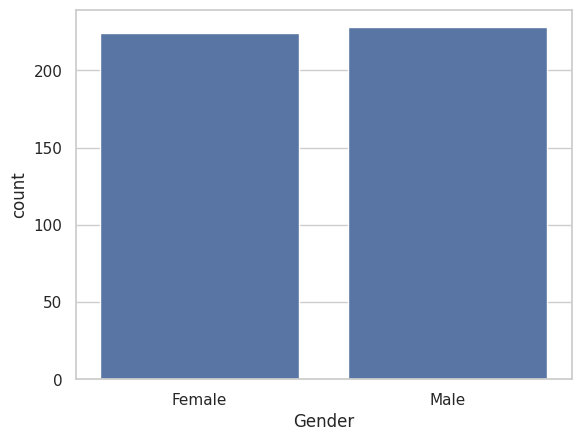

In [203]:
sns.countplot(x = "Gender", data = df)
plt.show()

The number of males and females are almost the same, meaning that the model will have no trouble leaning more to a certain type of classification when predicting.

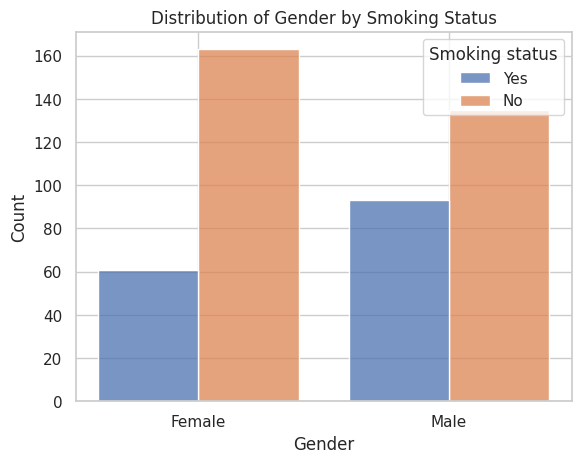

In [204]:
sns.histplot(data = df,
             x = 'Gender',
             hue = 'Smoking status',
             multiple= 'dodge',
             shrink = 0.8)
plt.title('Distribution of Gender by Smoking Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

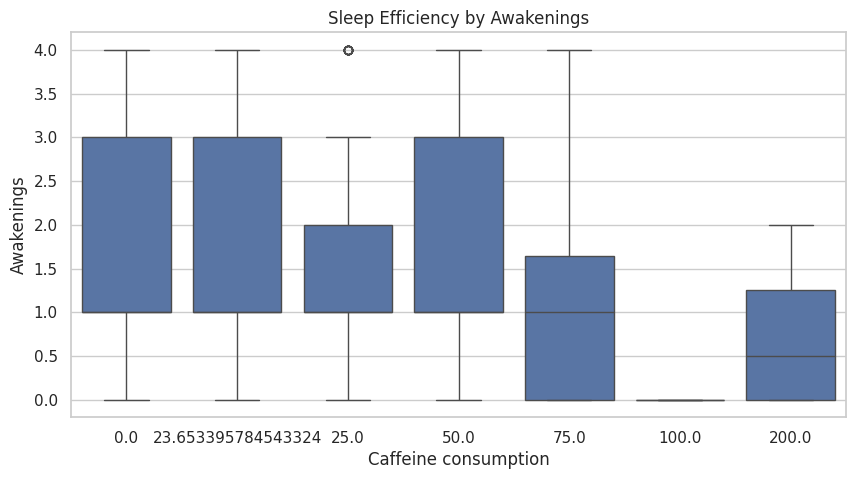

In [205]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Caffeine consumption', y='Awakenings', data=df)
plt.title('Sleep Efficiency by Awakenings')
plt.xlabel('Caffeine consumption')
plt.ylabel('Awakenings')
plt.show()

50% of individuals with 0mg, 23.65mg, and 50mg caffeine consumption tend to wake up 1-3 times a night. Meanwhile, individuals who have different caffeine intake tend to have imbalanced whisker lengths, indicating skweded distributions.

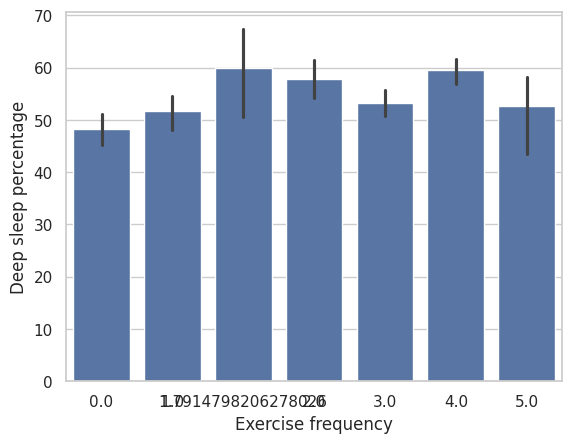

In [206]:
sns.barplot(
    data = df,
    x = 'Exercise frequency',
    y = 'Deep sleep percentage'
)
plt.xlabel('Exercise frequency')
plt.ylabel('Deep sleep percentage')
plt.show()

Individuals who do not exercise at all in a week seem have the lowest percentage in deep sleep. Though, no matter the exercise frequency, the deep sleep percentage of individuals does not drop lower than .40. So, we can conclude that exercise frequency does not have a big impact how much deep sleep an individual can experience.

### Getting sleeptime and wakeup time only (Vectorizing text columns)

In [209]:
df['Time'] = df['Bedtime'] + " " + df['Wakeup time']
df.drop(['Bedtime', 'Wakeup time'], axis = 1, inplace = True)

In [210]:
vectorizer = feature_extraction.text.CountVectorizer()
vectorized = vectorizer.fit_transform(df['Time'])

text_df = pd.DataFrame(vectorized.toarray(), columns = vectorizer.get_feature_names_out())
text_df.reset_index(drop = True, inplace = True)

df = pd.concat([df.drop(columns = ['Time']).reset_index(drop = True), text_df], axis = 1)
print(df)

      ID  Age  Gender  Sleep duration  Sleep efficiency  REM sleep percentage  \
0      1   65  Female             6.0              0.88                    18   
1      2   69    Male             7.0              0.66                    19   
2      3   40  Female             8.0              0.89                    20   
3      4   40  Female             6.0              0.51                    23   
4      5   57    Male             8.0              0.76                    27   
..   ...  ...     ...             ...               ...                   ...   
447  448   27  Female             7.5              0.91                    22   
448  449   52    Male             6.0              0.74                    28   
449  450   40  Female             8.5              0.55                    20   
450  451   45    Male             7.0              0.76                    18   
451  452   18    Male             7.5              0.63                    22   

     Deep sleep percentage 

### Getting the correlation matrix of the features

<function matplotlib.pyplot.show(close=None, block=None)>

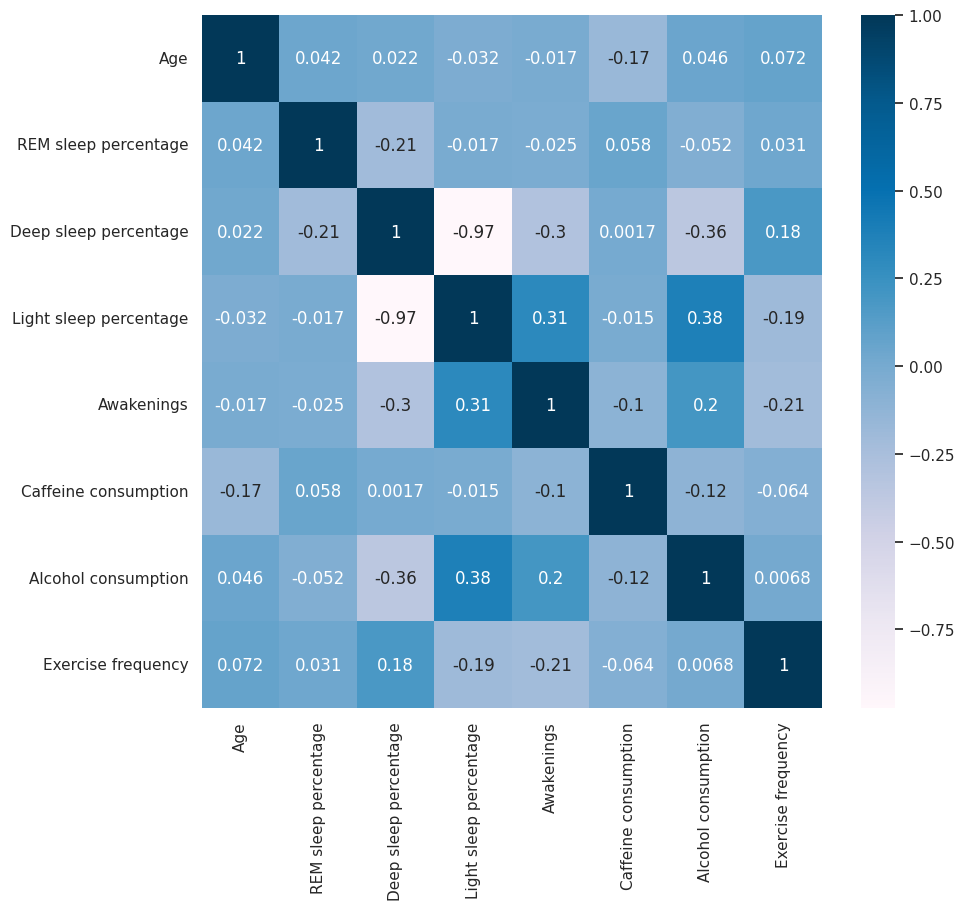

In [211]:
## correlation
corrMatrix = df[['Age', 'REM sleep percentage', 'Deep sleep percentage',
              'Light sleep percentage', 'Awakenings', 'Caffeine consumption', 'Alcohol consumption',
              'Exercise frequency']].corr()

plt.figure(figsize = (10, 9))
sns.heatmap(corrMatrix, annot = True, cmap = 'PuBu')
plt.show

The columns`Light sleep percentage` and `Deep sleep percentage` have a correlation of -0.97. Because this value is very close to -1, these two columns are tightly correlated and feeding both to the model will ultimately be redundant and inefficient. We can choose to remove one of them. In this case, we remove the `Light sleep percentage` column.

Meanwhile, the correlation of other columns with each other fall generally between 1 and -1. Thus, each column contributes differently to the data, and so it is imperative to keep them.

In [212]:
df.drop('Light sleep percentage', axis = 1, inplace = True)

### Removing unneccessary columns

Among all the other columns, the `ID` column is the only column that does not provide relevant information to determine sleep efficiency. Thus, remove it.

In [213]:
df.drop(['ID'], axis = 1, inplace = True)

### Checking and dealing with outliers

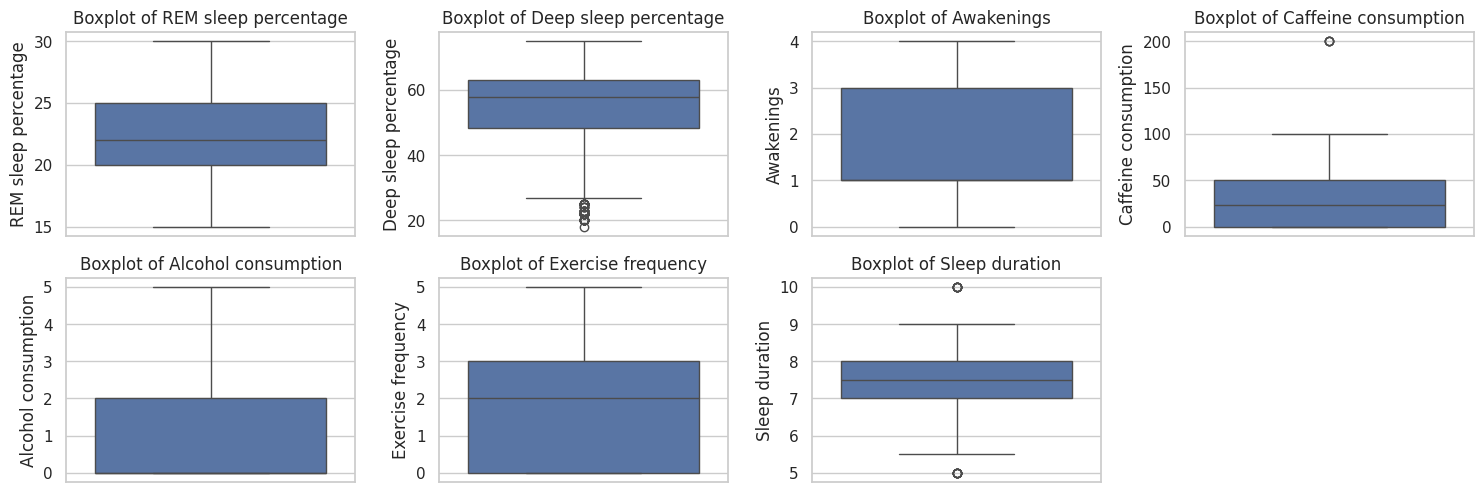

In [214]:
numCol = ['REM sleep percentage', 'Deep sleep percentage',
              'Awakenings', 'Caffeine consumption', 'Alcohol consumption',
              'Exercise frequency', 'Sleep duration']

plt.figure(figsize = (15, 10))
for i, column in enumerate(numCol, 1):
  plt.subplot(4, 4, i)
  sns.boxplot(df[column])
  plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

In [215]:
df['Caffeine consumption'] =  np.log(df['Caffeine consumption'] + 1)
df['Deep sleep percentage'] =  np.log(df['Deep sleep percentage'] + 1)
df['Sleep duration'] = np.log(df['Sleep duration'] + 1)

### Scaling values

Scale values that are continuous to ensure that all of those values contribute equally to the performance of the model.

In [216]:
df.columns

Index(['Age', 'Gender', 'Sleep duration', 'Sleep efficiency',
       'REM sleep percentage', 'Deep sleep percentage', 'Awakenings',
       'Caffeine consumption', 'Alcohol consumption', 'Smoking status',
       'Exercise frequency', '00', '01', '02', '03', '04', '05', '06', '07',
       '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '2021', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31'],
      dtype='object')

In [217]:
scaler = StandardScaler()
scaler.fit_transform(df[['Age', 'Sleep duration', 'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage',
               'Awakenings', 'Caffeine consumption', 'Alcohol consumption', 'Exercise frequency']])

array([[ 1.87834171, -1.77544423,  0.67426034, ..., -1.05235364,
        -0.73609454,  0.85285275],
       [ 2.18234688, -0.49240252, -0.95431503, ..., -1.05235364,
         1.14567243,  0.85285275],
       [-0.02169063,  0.63932047,  0.74828649, ..., -1.05235364,
        -0.73609454,  0.85285275],
       ...,
       [-0.02169063,  1.15882752, -1.76860272, ...,  0.65608213,
         1.14567243, -1.2642474 ],
       [ 0.35831583, -0.49240252, -0.2140535 , ..., -1.05235364,
        -0.73609454,  0.85285275],
       [-1.6937191 ,  0.09011157, -1.17639349, ...,  1.04357474,
        -0.73609454, -0.55854735]])

### Getting dummies in Smoking Status and Gender

Use one-hot encoding on `Gender` and `Smoking status` columns.

In [218]:
df = pd.get_dummies(df, columns = ['Gender', 'Smoking status'], drop_first = True)


##Training for Linear Regression

The training data set is 80% of the total data. That leaves 20% for the testing data.

In [219]:
##identifying X and Y values
X = df.drop('Sleep efficiency', axis=1)
y = df['Sleep efficiency']

In [224]:
## splitting train and test values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.22, random_state = 76)

In [225]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred) #r-squared value

In [226]:
print("Mean Squared Error", mse)
print("RMSE: ", math.sqrt(mse))
print("R-squared Error", r2)

print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

Mean Squared Error 0.004721647355946479
RMSE:  0.06871424419977622
R-squared Error 0.750081520374404
Coefficients:  [ 7.14041347e-04 -3.50228810e-02  6.12814204e-03  2.33493371e-01
 -3.27879215e-02  4.53534825e-03 -6.38364986e-03  8.79814989e-03
  5.88224880e-03 -1.91240172e-04 -1.67609077e-03 -8.55022761e-03
 -2.16706508e-03  7.37305745e-03 -5.21464969e-03 -3.18592973e-03
 -2.25287056e-03  6.56193320e-03 -6.93177041e-04 -6.13856128e-03
  4.47405597e-04  6.04417137e-03 -4.28776043e-03 -4.82070963e-03
  2.04560474e-02 -8.76691600e-03  5.81951973e-03 -1.07072649e-02
  1.45281219e-02  0.00000000e+00 -7.90721939e-03  4.35207093e-03
 -1.00506887e-02  1.47269185e-03 -1.07796962e-02  1.19221788e-02
 -1.53909068e-03  1.36615442e-02 -4.71162518e-03  7.39146352e-03
 -1.22716718e-02  5.17298438e-03 -3.57341731e-02]
Intercept:  -0.19098784552075942


## Interpretation

- The MSE is particularly small, which means that the difference between the actual values and the predicted values are very small. The model predictions for sleep efficiency must be very close to the actual sleep efficiency.


- Having a 0.0687 RMSE indicates that on average, the predicated values are off by 0.06 units.

- Having a negative intercept indicates that the dependent and independent variables have an inverse relationship.

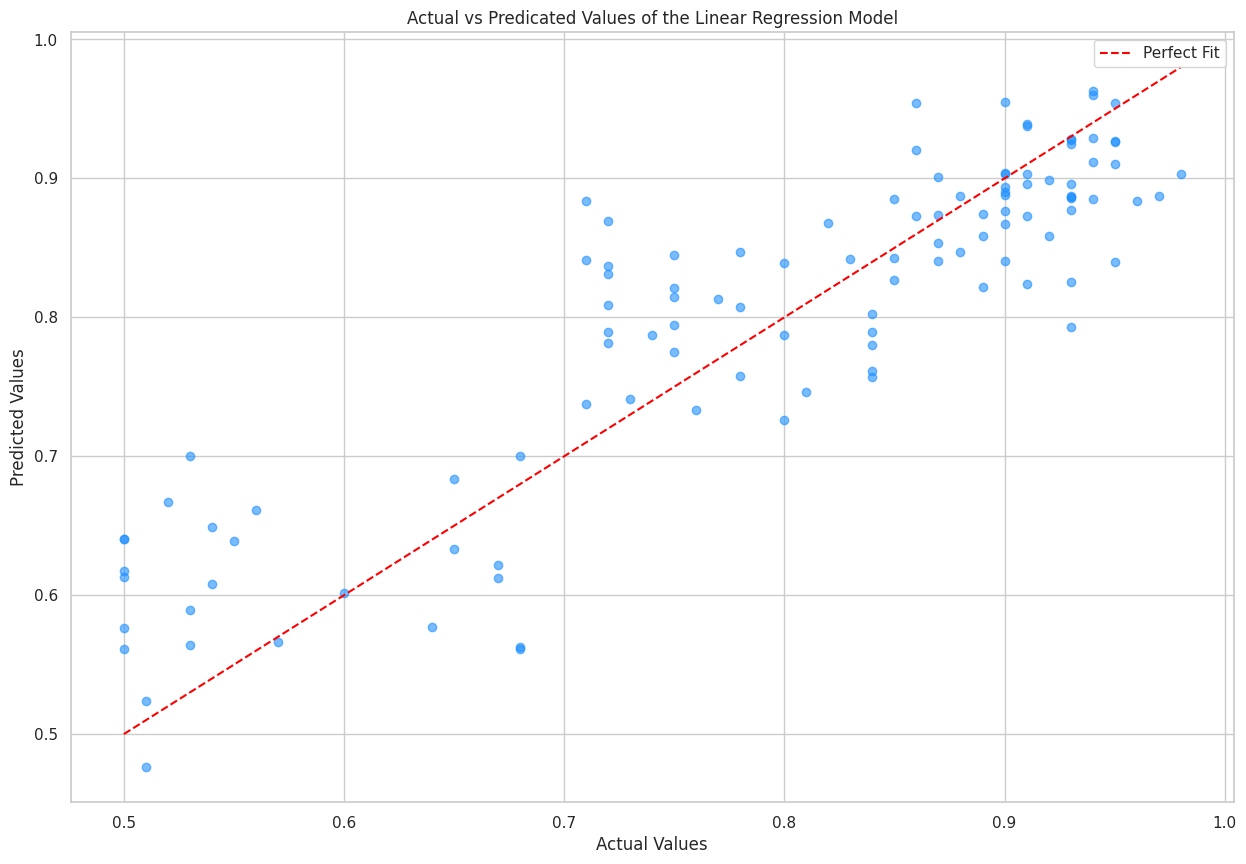

In [223]:
plt.figure(figsize = (15, 10))
plt.scatter(y_test, y_pred, color = 'dodgerblue', alpha = 0.6) #true values, predicted value
plt.plot([y_test.min(), y_test.max()],
 [y_test.min(), y_test.max()],
         color = 'red',
         linestyle = '--',
         label = 'Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicated Values of the Linear Regression Model')
plt.legend()
plt.grid(True)
plt.show()
